<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Description" data-toc-modified-id="Data-Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Description</a></span></li><li><span><a href="#Business-Problem" data-toc-modified-id="Business-Problem-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Business Problem</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Colab" data-toc-modified-id="Colab-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Colab</a></span></li><li><span><a href="#Useful-Functions" data-toc-modified-id="Useful-Functions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Useful Functions</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Data-Processing" data-toc-modified-id="Data-Processing-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Data Processing</a></span></li><li><span><a href="#Train-test-split" data-toc-modified-id="Train-test-split-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Train test split</a></span></li><li><span><a href="#Train-Validation-with-stratify" data-toc-modified-id="Train-Validation-with-stratify-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Train Validation with stratify</a></span></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Setup-Models" data-toc-modified-id="Setup-Models-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>Setup Models</a></span></li></ul></li><li><span><a href="#Fit-the-models" data-toc-modified-id="Fit-the-models-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Fit the models</a></span></li><li><span><a href="#Model-Comparison" data-toc-modified-id="Model-Comparison-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Model Comparison</a></span></li><li><span><a href="#Time-Taken" data-toc-modified-id="Time-Taken-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Time Taken</a></span></li></ul></div>

<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel,  Data Scientist, Ph.D Astrophysics</a> .
</div>

# Data Description

> The datasets contains transactions made by credit cards in September
2013 by european cardholders.


> This dataset presents transactions that occurred in two days,
where we have 492 frauds out of 284,807 transactions. 

> The dataset is highly unbalanced, the positive class (frauds)
account for 0.172% of all transactions.

> It contains only numerical input variables which are
the result of a PCA transformation.


> Unfortunately, due to confidentiality issues,
we cannot provide the original features and 
more background information about the data.


> Features V1, V2, ... V28 are the principal
components obtained with PCA,
the only features which have not been transformed with PCA are 'Time' and 'Amount'. 

> Feature 'Time' contains the seconds elapsed between each transaction
and the first transaction in the dataset. The feature 'Amount'
is the transaction Amount, this feature can be used for 
example-dependant cost-senstive learning. 

> Feature 'Class' is the response variable and it takes value
1 in case of fraud and 0 otherwise.

# Business Problem

<div class="alert alert-block alert-success">
<b>Business Problem:</b>  <br>
Task &nbsp;&nbsp; : Detect the fraudulent activities. <br>
Metric : Recall <br>
Sampling: Synthetic Minority Over-Sampling Technique (SMOTE) <br>
Question: How many frauds are correctly classified?
</div>

# Imports

In [1]:
import time

time_start_notebook = time.time()

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from pathlib import Path

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot') 

# random state
SEED = 0
RNG = np.random.RandomState(SEED)

home = os.path.expanduser('~')

# Models
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from mlxtend.classifier import StackingCVClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

%load_ext watermark
%watermark -a "Bhishan Poudel" -d -v -m
print()
%watermark -iv

Bhishan Poudel 2021-08-10 

CPython 3.7.7
IPython 7.22.0

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit

json     2.0.9
numpy    1.19.5
seaborn  0.11.0
autopep8 1.5.2
sklearn  0.23.1
pandas   1.3.0



In [3]:
# my local library
import sys
sys.path.append("/Users/poudel/Dropbox/a00_Bhishan_Modules/bhishan/")
from bhishan import bp

# Colab

In [4]:
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    !pip install catboost
    print('Environment: Google Colab')

# Useful Functions

In [5]:
def get_profit(y_true, y_pred):
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_true,y_pred).ravel()
    profit = 400*tp - 200*fn - 100*fp
    return profit

scoring = sklearn.metrics.make_scorer(get_profit, greater_is_better=True)

# Load the data

In [6]:
ifile = 'https://github.com/bhishanpdl/Datasets/blob/master/Projects/Fraud_detection/raw/creditcard.csv.zip?raw=true'
df = pd.read_csv(ifile,compression='zip')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
target = 'Class'
features = df.columns.drop(target)
df[target].value_counts(normalize=True)*100

0    99.827251
1     0.172749
Name: Class, dtype: float64

/Users/poudel/opt/miniconda3/envs/dataSc/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



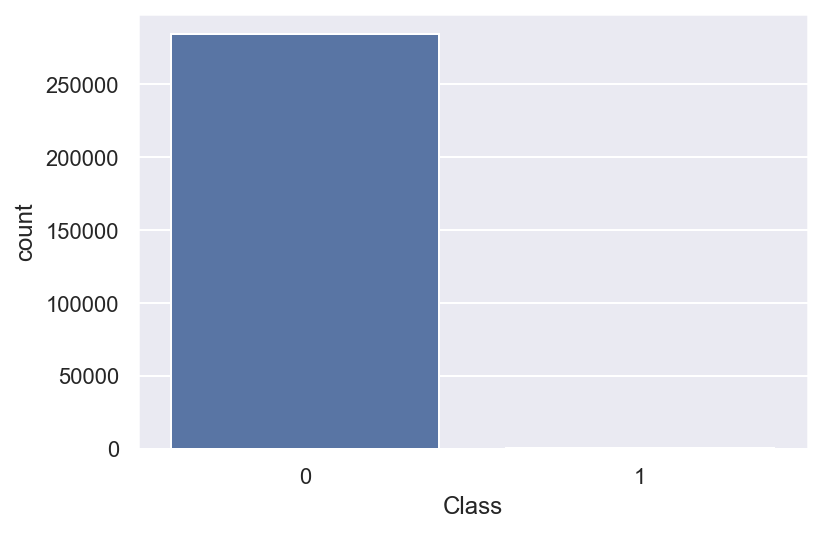

In [8]:
sns.countplot(df[target])

# Data Processing

# Train test split

In [9]:
from sklearn.model_selection import train_test_split

df_Xtrain_orig, df_Xtest, ser_ytrain_orig, ser_ytest = train_test_split(
    df.drop(target,axis=1), 
    df[target],
    test_size=0.2, 
    random_state=SEED, 
    stratify=df[target])

ytrain_orig = ser_ytrain_orig.to_numpy().ravel()
ytest = ser_ytest.to_numpy().ravel()

print(df_Xtrain_orig.shape)
df_Xtrain_orig.head()

(227845, 30)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
36001,38355.0,1.043949,0.318555,1.045810,2.805989,-0.561113,-0.367956,0.032736,-0.042333,-0.322674,...,-0.084556,-0.240105,-0.680315,0.085328,0.684812,0.318620,-0.204963,0.001662,0.037894,49.67
12844,22555.0,-1.665159,0.808440,1.805627,1.903416,-0.821627,0.934790,-0.824802,0.975890,1.747469,...,-0.373759,-0.335332,-0.510994,0.035839,0.147565,-0.529358,-0.566950,-0.595998,-0.220086,16.94
2873,2431.0,-0.324096,0.601836,0.865329,-2.138000,0.294663,-1.251553,1.072114,-0.334896,1.071268,...,-0.039868,0.012220,0.352856,-0.341505,-0.145791,0.094194,-0.804026,0.229428,-0.021623,1.00
145263,86773.0,-0.258270,1.217501,-0.585348,-0.875347,1.222481,-0.311027,1.073860,-0.161408,0.200665,...,0.382305,-0.424626,-0.781158,0.019316,0.178614,-0.315616,0.096665,0.269740,-0.020635,10.78
186658,127202.0,2.142162,-0.494988,-1.936511,-0.818288,-0.025213,-1.027245,-0.151627,-0.305750,-0.869482,...,0.106592,0.010115,0.021722,0.079463,-0.480899,0.023846,-0.279076,-0.030121,-0.043888,39.96


# Train Validation with stratify

In [10]:
df_Xtrain, df_Xvalid, ser_ytrain, ser_yvalid = train_test_split(
    df_Xtrain_orig, 
    ser_ytrain_orig,
    test_size=0.2, 
    random_state=SEED, 
    stratify=ser_ytrain_orig)


ytrain = ser_ytrain.to_numpy().ravel()
yvalid = ser_yvalid.to_numpy().ravel()

print(df_Xtrain.shape)

(182276, 30)


# Modelling

## Setup Models

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=None,
                           priors=None,
                           shrinkage=None,
                           solver='svd',
                           store_covariance=False,
                           tol=0.0001)

In [12]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


model_xgb = XGBClassifier(
    base_score=0.5,
    booster='gbtree',
    boosting_type='gbdt',
    colsample_by_tree=0.8040279979830232,
    colsample_bylevel=1,
    colsample_bytree=1,
    gamma=0,
    learning_rate=0.6183443388044544,
    max_delta_step=0,
    max_depth=7,
    min_child_weight=3.0,
    missing=None,
    n_estimators=150,
    n_jobs=-1,
    nthread=None,
    num_leaves=37,
    objective='binary:logistic',
    random_state=100,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1,
    seed=None,
    silent=True,
    subsample=0.8254724276776704
)

params_lgb = {
    'bagging_fraction': 0.5847570898839785,
    'bagging_freq': 3,
    'feature_fraction': 0.7941666171144979,
    'lambda_l1': 1.3871523892529368e-07,
    'lambda_l2': 0.44361819101899735,
    'min_child_samples': 55,
    'min_child_weight': 5.899155081455939,
    'num_leaves': 156,
    'subsample': 0.7122064897274488
}

model_lgb = LGBMClassifier(random_state=SEED, **params_lgb)

model_cb = CatBoostClassifier(verbose=False,random_state=100,
                            depth=6,
                            iterations=1_000,
                            )


In [13]:
# Stack up all the models
from mlxtend.classifier import StackingCVClassifier

stack = StackingCVClassifier(classifiers=(lda,model_xgb, model_lgb, model_cb),
                                meta_classifier=model_xgb,
                                use_features_in_secondary=True)

# Fit the models

In [14]:
%%time
lda.fit(np.array(df_Xtrain),np.array(ser_ytrain));

CPU times: user 1.24 s, sys: 155 ms, total: 1.39 s
Wall time: 3.6 s


LinearDiscriminantAnalysis()

In [15]:
%%time

model_xgb.fit(np.array(df_Xtrain),np.array(ser_ytrain));

[10:34:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { boosting_type, colsample_by_tree, num_leaves, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/Users/poudel/opt/miniconda3/envs/dataSc/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[10:34:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 2min 8s, sys: 574 ms, total: 2min 9s
Wall time: 1min 25s


XGBClassifier(base_score=0.5, booster='gbtree', boosting_type='gbdt',
              colsample_by_tree=0.8040279979830232, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.6183443388044544, max_delta_step=0, max_depth=7,
              min_child_weight=3.0, missing=None, monotone_constraints='()',
              n_estimators=150, n_jobs=-1, nthread=4, num_leaves=37,
              num_parallel_tree=1, random_state=100, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=100, silent=True,
              subsample=0.8254724276776704, tree_method='exact', ...)

In [16]:
%%time

model_lgb.fit(np.array(df_Xtrain),np.array(ser_ytrain));

CPU times: user 5.22 s, sys: 171 ms, total: 5.39 s
Wall time: 11.8 s


LGBMClassifier(bagging_fraction=0.5847570898839785, bagging_freq=3,
               feature_fraction=0.7941666171144979,
               lambda_l1=1.3871523892529368e-07, lambda_l2=0.44361819101899735,
               min_child_samples=55, min_child_weight=5.899155081455939,
               num_leaves=156, random_state=0, subsample=0.7122064897274488)

In [17]:
%%time
model_cb.fit(np.array(df_Xtrain),np.array(ser_ytrain));

CPU times: user 2min 13s, sys: 12.2 s, total: 2min 25s
Wall time: 6min 7s


In [18]:
%%time
stack.fit(np.array(df_Xtrain),np.array(ser_ytrain));

/Users/poudel/opt/miniconda3/envs/dataSc/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[10:42:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { boosting_type, colsample_by_tree, num_leaves, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:42:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:42:36] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Param

/Users/poudel/opt/miniconda3/envs/dataSc/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[10:44:11] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { boosting_type, colsample_by_tree, num_leaves, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:44:12] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/poudel/opt/miniconda3/envs/dataSc/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[10:45:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { boosting_type, colsample_by_tree, num_leaves, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:45:46] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 10min 56s, sys: 16.3 s, total: 11min 12s
Wall time: 4min 5s


StackingCVClassifier(classifiers=(LinearDiscriminantAnalysis(),
                                  XGBClassifier(base_score=0.5,
                                                booster='gbtree',
                                                boosting_type='gbdt',
                                                colsample_by_tree=0.8040279979830232,
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=1, gamma=0,
                                                gpu_id=-1,
                                                importance_type='gain',
                                                interaction_constraints='',
                                                learning_rate=0.6183443388044544,
                                                max_delta_step=0, max_dep...
                                                   learning_rate=0.618

# Model Comparison

In [19]:
%%time
ypreds_lda = lda.predict(np.array(df_Xtest))
ypreds_xgb = model_xgb.predict(np.array(df_Xtest))
ypreds_lgb = model_lgb.predict(np.array(df_Xtest))
ypreds_cb = model_cb.predict(np.array(df_Xtest))
ypreds_stack = stack.predict(np.array(df_Xtest))

CPU times: user 1.85 s, sys: 89.5 ms, total: 1.94 s
Wall time: 1.5 s


In [20]:
ytest = np.array(ser_ytest).ravel()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

ypreds = [ypreds_lda, ypreds_xgb, ypreds_lgb,ypreds_cb,ypreds_stack]
model_names = ['lda','xgboost','lightgbm','catboost','stack']
wrong_frauds = [confusion_matrix(ytest,ypred)[1,0] for ypred in ypreds]
accuracies = [accuracy_score(ytest,ypred) for ypred in ypreds]
precisions = [precision_score(ytest,ypred) for ypred in ypreds]
recalls = [recall_score(ytest,ypred) for ypred in ypreds]
f1_scores = [f1_score(ytest,ypred) for ypred in ypreds]

profits = [get_profit(ytest,ypred) for ypred in ypreds]

In [21]:
df_eval = pd.DataFrame({'Model': model_names,
                        'WrongFrauds': wrong_frauds,
                        'Accuracy': accuracies,
                        'Precision': precisions,
                        'Recall': recalls,
                        'F1-score': f1_scores,
                        'Profit': profits,
                       })


df_eval = df_eval.sort_values('Recall',ascending=False)
df_eval

,Model,WrongFrauds,Accuracy,Precision,Recall,F1-score
1,xgboost,25,0.999473,0.935897,0.744898,0.829545
4,stack,25,0.999544,0.986486,0.744898,0.848837
2,lightgbm,26,0.999438,0.923077,0.734694,0.818182
3,catboost,26,0.999473,0.947368,0.734694,0.827586
0,lda,28,0.999315,0.864198,0.714286,0.782123


In [22]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(ytest,ypreds_stack)
print(cm)

[[56863     1]
 [   25    73]]


In [23]:
wrong_frauds = cm[1,0]
wrong_frauds

25

# Time Taken

In [24]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

Time taken to run whole notebook: 0 hr 12 min 17 secs
